<a href="https://colab.research.google.com/github/HowonRyu/ConfidenceSet/blob/main/Independent_Studies_2023Winter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [86]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
import random
import sys
import os
import math
import scipy.stats
from tabulate import tabulate

!rm -rf ConfSets
!git clone https://github.com/TomMaullin/ConfSets.git
sys.path.append('/content/ConfSets/lib/')
from generateData import *
from boundary import *


!pip install git+https://github.com/HowonRyu/ConfidenceSet.git
from confidenceset.fdr_cope import *
#from confidenceset.plot import *
#from confidenceset.test import *

Cloning into 'ConfSets'...
remote: Enumerating objects: 1412, done.
remote: Counting objects: 100% (38/38), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 1412 (delta 21), reused 20 (delta 9), pack-reused 1374
Receiving objects: 100% (1412/1412), 359.84 KiB | 3.49 MiB/s, done.
Resolving deltas: 100% (993/993), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/HowonRyu/ConfidenceSet.git to /tmp/pip-req-build-3c53nsbd
  Running command git clone --filter=blob:none --quiet https://github.com/HowonRyu/ConfidenceSet.git /tmp/pip-req-build-3c53nsbd
  Resolved https://github.com/HowonRyu/ConfidenceSet.git to commit f73b53b5b4ee064577d72b5e4e59f360d6fa971a
  Preparing metadata (setup.py) ... done


# FDR Confidence Set


## Confidence Set controlling for FDR
\begin{array}{|c|c|} \hline
 & N & P &  \\ \hline
H_0 & TN & FP & m_0 \\
H_1 & FN & TP & m-m_0 \\ \hline
 & m-R & R & m \\ \hline
\end{array}


### Family Wise Error Rate (FWER)
*   $FWER = P(FP \ge 1 | H_0)$
*   In multiple testing, use Bonferroni to control for: $FWER <\frac{\alpha}{m}$



### False Discovery Rate (FDR)

*   $FDR = E(\frac{FP}{R} | R>0)P(R>0) = E \frac{FP}{\max(1,R)} $
*  ((If you can add BH proof))

## Simulation

Different settings of image size and variance

In [70]:
# Circle/square mu and noise specs
mu_spec_circle_l_100 = {'type': 'circle2D', 
                  'center': np.array([0,0]), 
                  'fwhm': np.array([4,4]), 
                  'r': np.array(49), 
                  'mag': np.array(3)}

mu_spec_circle_s_100 = {'type': 'circle2D', 
                  'center': np.array([0,0]), 
                  'fwhm': np.array([4,4]), 
                  'r': np.array(25), 
                  'mag': np.array(3)}


mu_spec_circle_l_50 = {'type': 'circle2D', 
                  'center': np.array([0,0]), 
                  'fwhm': np.array([4/2,4/2]), 
                  'r': np.array(int(49/2)), 
                  'mag': np.array(3)}

mu_spec_circle_s_50 = {'type': 'circle2D', 
                  'center': np.array([0,0]), 
                  'fwhm': np.array([4/2,4/2]), 
                  'r': np.array( int(25/2)), 
                  'mag': np.array(3)}

no_signal = {'type': 'ramp2D',
                'a': np.array([0]),
                'b': np.array([0]),
                'orient':'horizontal'}

noise_spec_homogen = {'FWHM': [0, 0, 0],
                      'mag': np.array(3),
                      'type': 'homogen'}                      

noise_spec_homogen_smth = {'FWHM': [0, 7, 7],
                           'mag': np.array(3),
                      'type': 'homogen'}                      


#image dimension
n_subj=80
img_dim50=(50, 50)
field_dim50 = np.array((n_subj,) + img_dim50)
img_dim100=(100, 100)
field_dim100 = np.array((n_subj,) + img_dim100)

#generating noise and mu
noise = get_noise(noise_spec_homogen, field_dim50) 
noise100 = get_noise(noise_spec_homogen, field_dim100) 
noise_smth= get_noise(noise_spec_homogen_smth, field_dim50)

mu_circular_l = get_mu(mu_spec_circle_l_50, field_dim50)
mu_circular_s = get_mu(mu_spec_circle_s_50, field_dim50)

mu_circular_l100 = get_mu(mu_spec_circle_l_100, field_dim100)
mu_circular_s100 = get_mu(mu_spec_circle_s_100, field_dim100)

mu_no_signal = get_mu(no_signal, field_dim50)

#putting together noise and mu, noise ~ MVN(0,sigma=3)
circular_l = mu_circular_l + noise
circular_l100 = mu_circular_l100 + noise100
circular_l_smth = mu_circular_l + noise_smth
no_signal_img = mu_no_signal + noise

circular_s = mu_circular_s + noise
circular_s100 = mu_circular_s100 + noise100
circular_s_smth = mu_circular_s + noise_smth

Signals

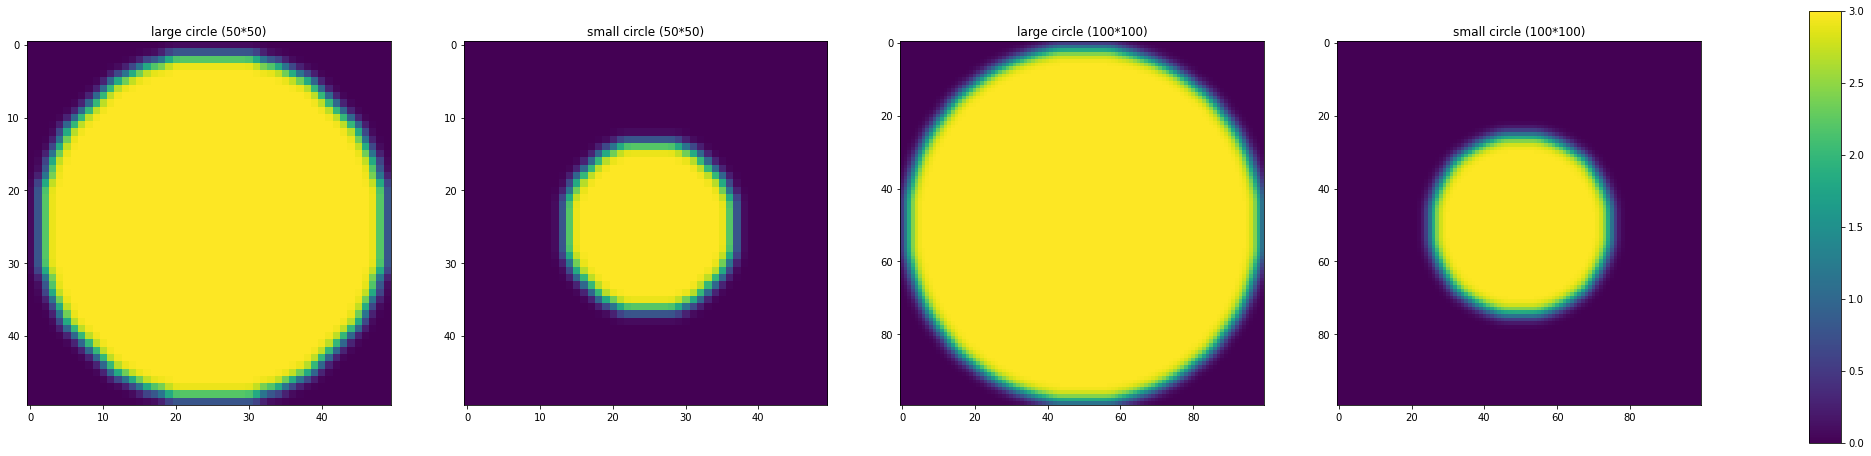

In [71]:
fig, axs = plt.subplots(1, 4, figsize=(30, 20))


im = axs[0].imshow(mu_circular_l[0,:,:])
axs[0].set_title("large circle (50*50)")
#plt.colorbar(im00, ax=axs[0, 0])

im = axs[1].imshow(mu_circular_s[0,:,:])
axs[1].set_title("small circle (50*50)")
#plt.colorbar(im01, ax=axs[0, 1])

im = axs[2].imshow(mu_circular_l100[0,:,:])
axs[2].set_title("large circle (100*100)")
#plt.colorbar(im02, ax=axs[0, 2])

im = axs[3].imshow(mu_circular_s100[0,:,:])
axs[3].set_title("small circle (100*100)")
#plt.colorbar(im03, ax=axs[0, 3])

cbar_ax = fig.add_axes([0.95, 0.35, 0.015, 0.3])
fig.colorbar(im, cax=cbar_ax)
plt.show()

See how one-sided and two-sided tests and sub-setting for inner and outer confidence sets are constructd

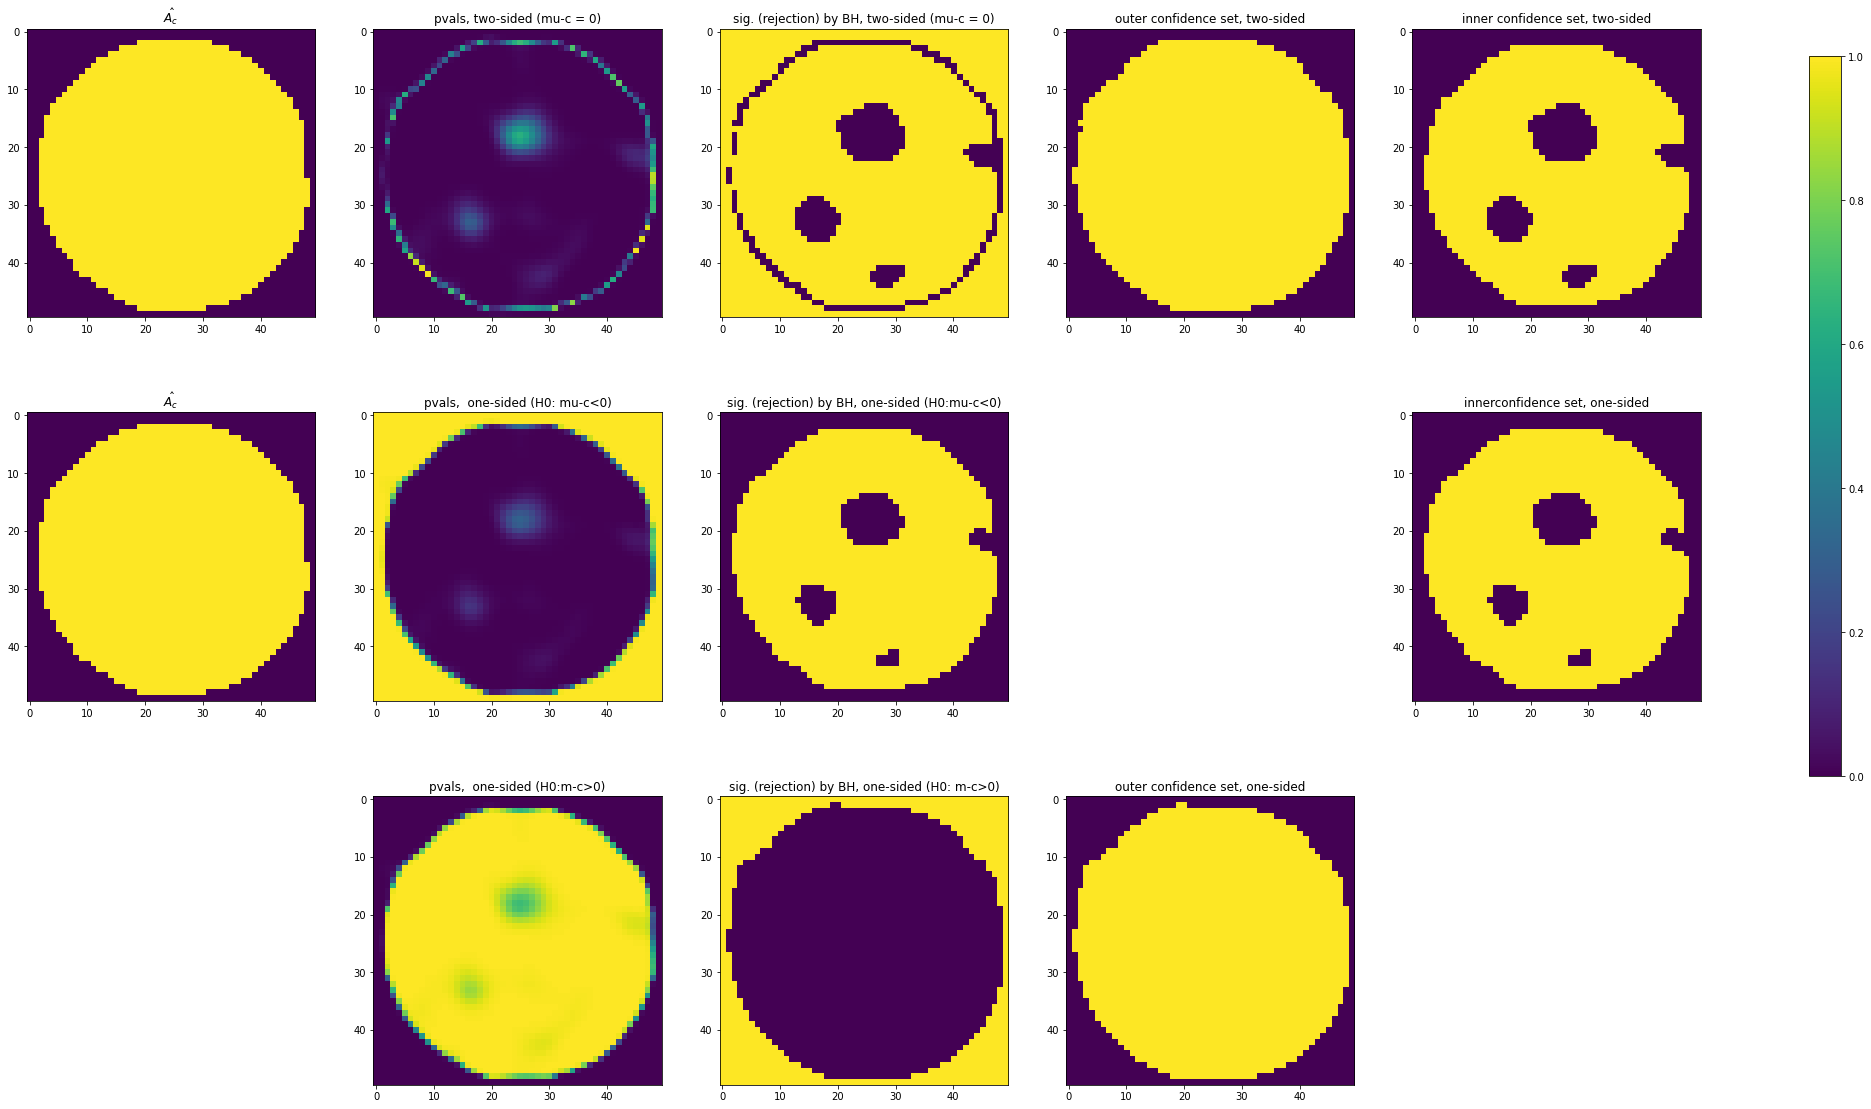

threshold = c = 2


In [72]:
data = circular_l_smth
threshold = 2
alpha = 0.05

data_tstat = mvtstat(data - threshold)
data_dim = data.shape

nsubj = data_dim[0]
Achat = data_tstat >= 0
Achat_C = data_tstat < 0

# two one-sided tests
inner_pvals = 1 - scipy.stats.t.cdf(data_tstat, df=nsubj - 1)
outer_pvals = scipy.stats.t.cdf(data_tstat, df=nsubj - 1)
inner_rejection_ind, _, _ = fdrBH(inner_pvals, alpha)
outer_rejection_ind, _, _ = fdrBH(outer_pvals, alpha)
outer_set_1 = 1- Achat_C*outer_rejection_ind
inner_set_1 = Achat*inner_rejection_ind


# a two sided test
pvals = 2*(1 - scipy.stats.t.cdf(abs(data_tstat), df=nsubj - 1))
rejection_ind, _, _ = fdrBH(pvals, alpha)
outer_set_2 = 1- Achat_C * rejection_ind
inner_set_2 = Achat*rejection_ind
  


fig, axs = plt.subplots(3, 5, figsize=(30, 20))

_min, _max = 0,1

im = axs[0, 0].imshow(Achat)
axs[0, 0].set_title("$\hat{A_c}$")
#plt.colorbar(im00, ax=axs[0, 0])

im = axs[1, 0].imshow(Achat)
axs[1, 0].set_title("$\hat{A_c}$")
#plt.colorbar(im00, ax=axs[0, 0])


im = axs[0, 1].imshow(pvals, vmin = _min, vmax = _max)
axs[0, 1].set_title("pvals, two-sided (mu-c = 0)")
#plt.colorbar(im02, ax=axs[0, 2])

im = axs[1, 1].imshow(inner_pvals, vmin = _min, vmax = _max)
axs[1, 1].set_title("pvals,  one-sided (H0: mu-c<0)")
#plt.colorbar(im03, ax=axs[0, 3])

im = axs[2, 1].imshow(outer_pvals, vmin = _min, vmax = _max)
axs[2, 1].set_title("pvals,  one-sided (H0:m-c>0)")
#plt.colorbar(im03, ax=axs[0, 3])




im = axs[0, 2].imshow(rejection_ind, vmin = _min, vmax = _max)
axs[0, 2].set_title("sig. (rejection) by BH, two-sided (mu-c = 0)")
#plt.colorbar(im02, ax=axs[0, 2])

im = axs[1, 2].imshow(inner_rejection_ind, vmin = _min, vmax = _max)
axs[1, 2].set_title("sig. (rejection) by BH, one-sided (H0:mu-c<0)")
#plt.colorbar(im03, ax=axs[0, 3])

im = axs[2, 2].imshow(outer_rejection_ind, vmin = _min, vmax = _max)
axs[2, 2].set_title("sig. (rejection) by BH, one-sided (H0: m-c>0)")
#plt.colorbar(im03, ax=axs[0, 3])



im = axs[0, 3].imshow(outer_set_2, vmin = _min, vmax = _max)
axs[0, 3].set_title("outer confidence set, two-sided")
#plt.colorbar(im02, ax=axs[0, 2])

im = axs[2, 3].imshow(outer_set_1, vmin = _min, vmax = _max)
axs[2,3].set_title("outer confidence set, one-sided")
#plt.colorbar(im03, ax=axs[0, 3])


im = axs[0, 4].imshow(inner_set_2, vmin = _min, vmax = _max)
axs[0, 4].set_title("inner confidence set, two-sided")
#plt.colorbar(im02, ax=axs[0, 2])

im = axs[1, 4].imshow(inner_set_1, vmin = _min, vmax = _max)
axs[1,4].set_title("innerconfidence set, one-sided")
#plt.colorbar(im03, ax=axs[0, 3])


axs[2,0].text(0.5, 0.5, s='',
              fontsize = 20,horizontalalignment='center',
              verticalalignment='center')
axs[2,0].set_axis_off()


axs[1,3].text(0.5, 0.5, s='',
               fontsize = 20, horizontalalignment='center',
     verticalalignment='center')
axs[1,3].set_axis_off()

axs[2,4].text(0.5, 0.5, s='',
               fontsize = 20, horizontalalignment='center',
     verticalalignment='center')
axs[2,4].set_axis_off()


cbar_ax = fig.add_axes([0.95, 0.35, 0.015, 0.5])
fig.colorbar(im, cax=cbar_ax, cmap='Greys')

plt.show()
print("threshold = c = 2")

#    outer_set = 1- Achat_C*outer_rejection_ind = Achat {Union} rejection_ind complement
#    inner_set = Achat*inner_rejection_ind

In [ ]:
def fdr_cope(data, threshold, alpha=0.05, tail="two"):
  """ 
  sub-setting the confidence set controlling for FDR
  Parameters
  ----------
  data : int
    array of voxels
  threshold : int
    threshold to be used for sub-setting
  alpha : int
    significance level
    
  Returns
  -------
  lower_set : Boolean
    voxels denoting the lower confidence set
  upper_set : Boolean
    voxels denoting the upper confidence set
  Example
  -------
  nsub = 50
  data = numpy.random.randn(nsub, 100, 100) + 2
  lower, upper = fdr_cope(data, threshold=2, alpha=0.05, tail="two)
  plt.imshow(lower)
  plt.imshow(upper)
  :Authors:
    Samuel Davenport <sdavenport@health.ucsd.edu>
    Howon Ryu <howonryu@ucsd.edu>
  """
  data_tstat = mvtstat(data - threshold)
  data_dim = data.shape
  nsubj = data_dim[0]
  Achat = data_tstat >= 0
  Achat_C = data_tstat < 0

  if tail == "two":
    pvals = 2*(1 - scipy.stats.t.cdf(abs(data_tstat), df=nsubj - 1))

    rejection_ind, _, n_rej = fdrBH(pvals, alpha)
    outer_set = 1- Achat_C*rejection_ind
    inner_set = Achat*rejection_ind

  if tail == "one":
    inner_pvals = 1 - scipy.stats.t.cdf(data_tstat, df=nsubj - 1)
    outer_pvals = scipy.stats.t.cdf(data_tstat, df=nsubj - 1)

    inner_rejection_ind, _, n_rej = fdrBH(inner_pvals, alpha)
    outer_rejection_ind, _, n_rej = fdrBH(outer_pvals, alpha)
    outer_set = 1- Achat_C*outer_rejection_ind
    inner_set = Achat*inner_rejection_ind

  return(outer_set, inner_set, Achat, n_rej)

Now we look at $\hat{A}_c^+, \hat{A}_c^-$, and $\hat{A}_c$

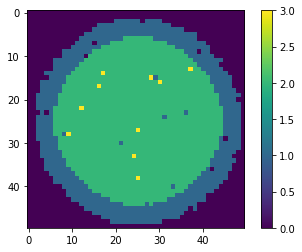

In [ ]:
test1, test2, Achatl2, Acircular_l2, _  = fdr_cope(circular_l, threshold=3, alpha=0.05, tail="two")

temp = (mu_circular_l[0,:,:]==3)
plt.imshow(test1 + test2 + temp)
#plt.imshow(mu_circular_l[0,:,:])
plt.colorbar()
plt.show()


#Todo

#do the Ac as well
#make functions... make it simpler. c, mu, ac -> ac_hat+uppwer+lower 
# do the write up for the sim justifying the result
#FWE
 #BH th/ E[] <= alpham0/m


ValueError: ignored

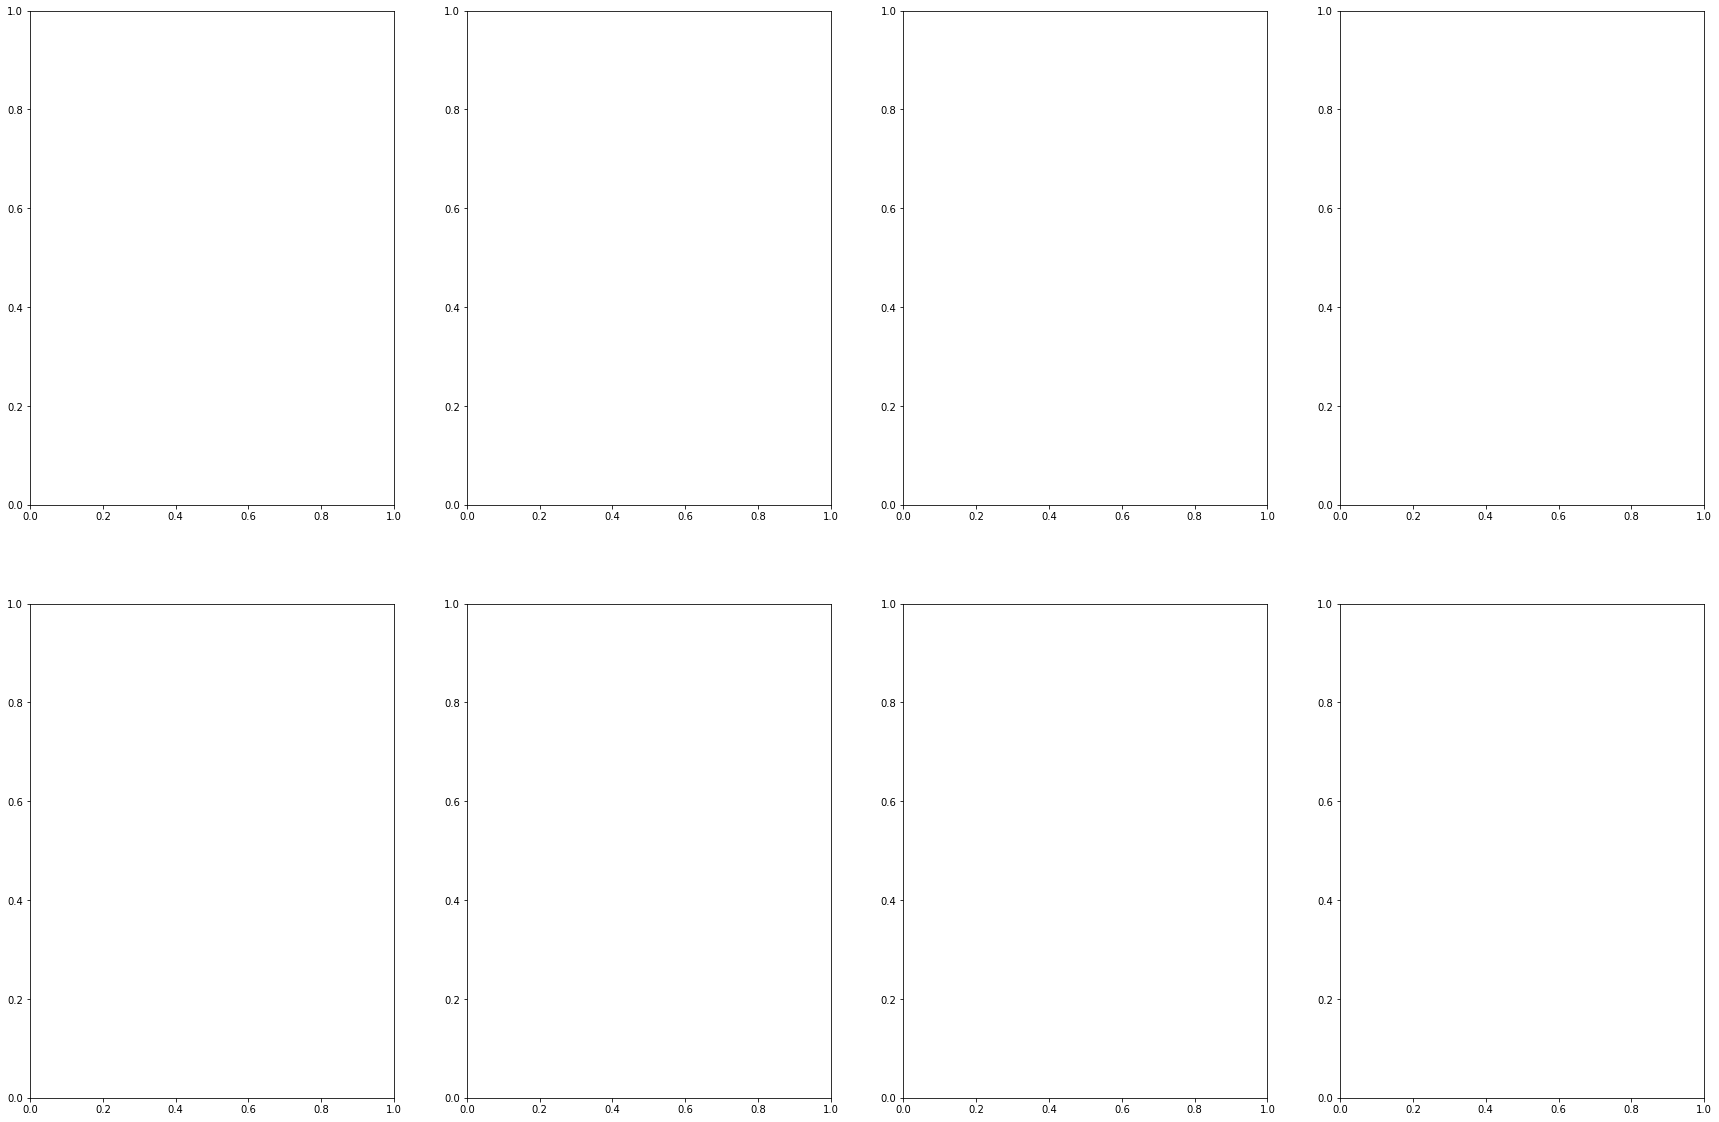

In [88]:
conf_plot_agg(c=3, _min=0, _max=3)


# FDR and coverage

## 1) FWE inclusion: $\{\hat{A}_c^+ \subset A_c \subset \hat{A}_c^-\}$ check


In [ ]:
def fdr_error_check(n_subj, img_dim, c, noise_set, mu_set,
                    var=1, alpha=0.05, tail="two"):
  
  data_dim = np.array((n_subj,) + img_dim)
  noise = get_noise(noise_set, data_dim)*var
  mu = get_mu(mu_set, data_dim)
  data = mu + noise

  lower, upper, Achat, all_sets, _ = fdr_cope(data, threshold=c, alpha=0.05, tail=tail)
  Ac = mu>=c
  AcC = 1-Ac
  upper_inclusion = 1 - np.any( AcC * upper > 0 )
  lower_inclusion = 1 - np.any( Ac * (1-lower)> 0 )
  inclusion = upper_inclusion * lower_inclusion
  exclusion = 1-inclusion
  return(exclusion)

**Sanity check: No signal image with c=0 (expecting ~0.05 violation of inclusion)**

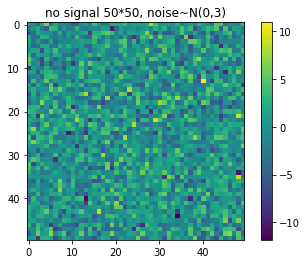

NameError: ignored

In [ ]:
plt.imshow(no_signal_img[0,:,:])
plt.colorbar()
plt.title("no signal 50*50, noise~N(0,3)")
plt.show()

exclusion1 = []
num_sim=1000
for i in np.arange(num_sim):
  exclusion1.append(fdr_error_check(n_subj=80, img_dim=(50,50), c=0,
                                   noise_set=noise_spec_homogen, mu_set=no_signal,
                                   var=1, alpha=0.05, tail="two"))

print("50*50 no signal ERR:", np.mean(exclusion1))

exclusion2 = []
num_sim=1000
for i in np.arange(num_sim):
  exclusion2.append(fdr_error_check(n_subj=80, img_dim=(100,100), c=0,
                                   noise_set=noise_spec_homogen, mu_set=no_signal,
                                   var=1, alpha=0.05, tail="two"))

print("100*100 no signal ERR:", np.mean(exclusion2))

In [ ]:
sim_num = 100
ERR_FWE = dict()
ERR_FWE['lab'] = ["c=0.5", "c=2", "c=3",
               "c=0.5/std=*3", "c=2/std=*3", "c=3/std=*3"]
ERR_FWE['small'] = [[],[],[],[],[],[]]
for i in np.arange(sim_num):
  ERR_FWE['small'][0].append(fdr_error_check(n_subj=80, img_dim=(50,50), c=0.5, var=1,
                    noise_set=noise_spec_homogen, mu_set=mu_spec_circle_s_50,
                    alpha=0.05, tail="two"))
  ERR_FWE['small'][1].append(fdr_error_check(n_subj=80, img_dim=(50,50), c=2, var=1,
                    noise_set=noise_spec_homogen, mu_set=mu_spec_circle_s_50,
                    alpha=0.05, tail="two"))
  ERR_FWE['small'][2].append(fdr_error_check(n_subj=80, img_dim=(50,50), c=3, var=1,
                    noise_set=noise_spec_homogen, mu_set=mu_spec_circle_s_50,
                    alpha=0.05, tail="two"))
  ERR_FWE['small'][3].append(fdr_error_check(n_subj=80, img_dim=(50,50), c=0.5, var=3,
                    noise_set=noise_spec_homogen, mu_set=mu_spec_circle_s_50,
                    alpha=0.05, tail="two"))
  ERR_FWE['small'][4].append(fdr_error_check(n_subj=80, img_dim=(50,50), c=2, var=3,
                    noise_set=noise_spec_homogen, mu_set=mu_spec_circle_s_50,
                    alpha=0.05, tail="two"))
  ERR_FWE['small'][5].append(fdr_error_check(n_subj=80, img_dim=(50,50), c=3, var=3,
                    noise_set=noise_spec_homogen, mu_set=mu_spec_circle_s_50,
                    alpha=0.05, tail="two"))

ERR_FWE['small_smth'] = [[],[],[],[],[],[]]
for i in np.arange(sim_num):
  ERR_FWE['small_smth'][0].append(fdr_error_check(n_subj=80, img_dim=(50,50), c=0.5, var=1,
                    noise_set=noise_spec_homogen_smth, mu_set=mu_spec_circle_s_50,
                    alpha=0.05, tail="two"))
  ERR_FWE['small_smth'][1].append(fdr_error_check(n_subj=80, img_dim=(50,50), c=2, var=1,
                    noise_set=noise_spec_homogen_smth, mu_set=mu_spec_circle_s_50,
                    alpha=0.05, tail="two"))
  ERR_FWE['small_smth'][2].append(fdr_error_check(n_subj=80, img_dim=(50,50), c=3, var=1,
                    noise_set=noise_spec_homogen_smth, mu_set=mu_spec_circle_s_50,
                    alpha=0.05, tail="two"))
  ERR_FWE['small_smth'][3].append(fdr_error_check(n_subj=80, img_dim=(50,50), c=0.5, var=3,
                    noise_set=noise_spec_homogen_smth, mu_set=mu_spec_circle_s_50,
                    alpha=0.05, tail="two"))
  ERR_FWE['small_smth'][4].append(fdr_error_check(n_subj=80, img_dim=(50,50), c=2, var=3,
                    noise_set=noise_spec_homogen_smth, mu_set=mu_spec_circle_s_50,
                    alpha=0.05, tail="two"))
  ERR_FWE['small_smth'][5].append(fdr_error_check(n_subj=80, img_dim=(50,50), c=3, var=3,
                    noise_set=noise_spec_homogen_smth, mu_set=mu_spec_circle_s_50,
                    alpha=0.05, tail="two"))

ERR_FWE['large'] = [[],[],[],[],[],[]]
for i in np.arange(sim_num):
  ERR_FWE['large'][0].append(fdr_error_check(n_subj=80, img_dim=(50,50), c=0.5, var=1,
                    noise_set=noise_spec_homogen, mu_set=mu_spec_circle_l_50,
                    alpha=0.05, tail="two"))
  ERR_FWE['large'][1].append(fdr_error_check(n_subj=80, img_dim=(50,50), c=2, var=1,
                    noise_set=noise_spec_homogen, mu_set=mu_spec_circle_l_50,
                    alpha=0.05, tail="two"))
  ERR_FWE['large'][2].append(fdr_error_check(n_subj=80, img_dim=(50,50), c=3, var=1,
                    noise_set=noise_spec_homogen, mu_set=mu_spec_circle_l_50,
                    alpha=0.05, tail="two"))
  ERR_FWE['large'][3].append(fdr_error_check(n_subj=80, img_dim=(50,50), c=0.5, var=3,
                    noise_set=noise_spec_homogen, mu_set=mu_spec_circle_l_50,
                    alpha=0.05, tail="two"))
  ERR_FWE['large'][4].append(fdr_error_check(n_subj=80, img_dim=(50,50), c=2, var=3,
                    noise_set=noise_spec_homogen, mu_set=mu_spec_circle_l_50,
                    alpha=0.05, tail="two"))
  ERR_FWE['large'][5].append(fdr_error_check(n_subj=80, img_dim=(50,50), c=3, var=3,
                    noise_set=noise_spec_homogen, mu_set=mu_spec_circle_l_50,
                    alpha=0.05, tail="two"))
  
ERR_FWE['large_smth'] = [[],[],[],[],[],[]]
for i in np.arange(sim_num):
  ERR_FWE['large_smth'][0].append(fdr_error_check(n_subj=80, img_dim=(50,50), c=0.5, var=1,
                    noise_set=noise_spec_homogen_smth, mu_set=mu_spec_circle_l_50,
                    alpha=0.05, tail="two"))
  ERR_FWE['large_smth'][1].append(fdr_error_check(n_subj=80, img_dim=(50,50), c=2, var=1,
                    noise_set=noise_spec_homogen_smth, mu_set=mu_spec_circle_l_50,
                    alpha=0.05, tail="two"))
  ERR_FWE['large_smth'][2].append(fdr_error_check(n_subj=80, img_dim=(50,50), c=3, var=1,
                    noise_set=noise_spec_homogen_smth, mu_set=mu_spec_circle_l_50,
                    alpha=0.05, tail="two"))
  ERR_FWE['large_smth'][3].append(fdr_error_check(n_subj=80, img_dim=(50,50), c=0.5, var=3,
                    noise_set=noise_spec_homogen_smth, mu_set=mu_spec_circle_l_50,
                    alpha=0.05, tail="two"))
  ERR_FWE['large_smth'][4].append(fdr_error_check(n_subj=80, img_dim=(50,50), c=2, var=3,
                    noise_set=noise_spec_homogen_smth, mu_set=mu_spec_circle_l_50,
                    alpha=0.05, tail="two"))
  ERR_FWE['large_smth'][5].append(fdr_error_check(n_subj=80, img_dim=(50,50), c=3, var=3,
                    noise_set=noise_spec_homogen_smth, mu_set=mu_spec_circle_l_50,
                    alpha=0.05, tail="two"))


ERR_FWE.update({n: np.round(np.nanmean(ERR_FWE[n],axis=1),4) for n in list(ERR_FWE.keys())[1:]})


In [ ]:
sim_num = 100
ERR_FWE2 = dict()
ERR_FWE2['lab'] = ["c=0.5", "c=2", "c=3",
               "c=0.5/std=*3", "c=2/std=*3", "c=3/std=*3"]
ERR_FWE2['small'] = [[],[],[],[],[],[]]
for i in np.arange(sim_num):
  ERR_FWE2['small'][0].append(fdr_error_check(n_subj=80, img_dim=(100,100), c=0.5, var=1,
                    noise_set=noise_spec_homogen, mu_set=mu_spec_circle_s_100,
                    alpha=0.05, tail="two"))
  ERR_FWE2['small'][1].append(fdr_error_check(n_subj=80, img_dim=(100,100), c=2, var=1,
                    noise_set=noise_spec_homogen, mu_set=mu_spec_circle_s_100,
                    alpha=0.05, tail="two"))
  ERR_FWE2['small'][2].append(fdr_error_check(n_subj=80, img_dim=(100,100), c=3, var=1,
                    noise_set=noise_spec_homogen, mu_set=mu_spec_circle_s_100,
                    alpha=0.05, tail="two"))
  ERR_FWE2['small'][3].append(fdr_error_check(n_subj=80, img_dim=(100,100), c=0.5, var=3,
                    noise_set=noise_spec_homogen, mu_set=mu_spec_circle_s_100,
                    alpha=0.05, tail="two"))
  ERR_FWE2['small'][4].append(fdr_error_check(n_subj=80, img_dim=(100,100), c=2, var=3,
                    noise_set=noise_spec_homogen, mu_set=mu_spec_circle_s_100,
                    alpha=0.05, tail="two"))
  ERR_FWE2['small'][5].append(fdr_error_check(n_subj=80, img_dim=(100,100), c=3, var=3,
                    noise_set=noise_spec_homogen, mu_set=mu_spec_circle_s_100,
                    alpha=0.05, tail="two"))

ERR_FWE2['small_smth'] = [[],[],[],[],[],[]]
for i in np.arange(sim_num):
  ERR_FWE2['small_smth'][0].append(fdr_error_check(n_subj=80, img_dim=(100,100), c=0.5, var=1,
                    noise_set=noise_spec_homogen_smth, mu_set=mu_spec_circle_s_100,
                    alpha=0.05, tail="two"))
  ERR_FWE2['small_smth'][1].append(fdr_error_check(n_subj=80, img_dim=(100,100), c=2, var=1,
                    noise_set=noise_spec_homogen_smth, mu_set=mu_spec_circle_s_100,
                    alpha=0.05, tail="two"))
  ERR_FWE2['small_smth'][2].append(fdr_error_check(n_subj=80, img_dim=(100,100), c=3, var=1,
                    noise_set=noise_spec_homogen_smth, mu_set=mu_spec_circle_s_100,
                    alpha=0.05, tail="two"))
  ERR_FWE2['small_smth'][3].append(fdr_error_check(n_subj=80, img_dim=(100,100), c=0.5, var=3,
                    noise_set=noise_spec_homogen_smth, mu_set=mu_spec_circle_s_100,
                    alpha=0.05, tail="two"))
  ERR_FWE2['small_smth'][4].append(fdr_error_check(n_subj=80, img_dim=(100,100), c=2, var=3,
                    noise_set=noise_spec_homogen_smth, mu_set=mu_spec_circle_s_100,
                    alpha=0.05, tail="two"))
  ERR_FWE2['small_smth'][5].append(fdr_error_check(n_subj=80, img_dim=(100,100), c=3, var=3,
                    noise_set=noise_spec_homogen_smth, mu_set=mu_spec_circle_s_100,
                    alpha=0.05, tail="two"))

ERR_FWE2['large'] = [[],[],[],[],[],[]]
for i in np.arange(sim_num):
  ERR_FWE2['large'][0].append(fdr_error_check(n_subj=80, img_dim=(100,100), c=0.5, var=1,
                    noise_set=noise_spec_homogen, mu_set=mu_spec_circle_l_100,
                    alpha=0.05, tail="two"))
  ERR_FWE2['large'][1].append(fdr_error_check(n_subj=80, img_dim=(100,100), c=2, var=1,
                    noise_set=noise_spec_homogen, mu_set=mu_spec_circle_l_100,
                    alpha=0.05, tail="two"))
  ERR_FWE2['large'][2].append(fdr_error_check(n_subj=80, img_dim=(100,100), c=3, var=1,
                    noise_set=noise_spec_homogen, mu_set=mu_spec_circle_l_100,
                    alpha=0.05, tail="two"))
  ERR_FWE2['large'][3].append(fdr_error_check(n_subj=80, img_dim=(100,100), c=0.5, var=3,
                    noise_set=noise_spec_homogen, mu_set=mu_spec_circle_l_100,
                    alpha=0.05, tail="two"))
  ERR_FWE2['large'][4].append(fdr_error_check(n_subj=80, img_dim=(100,100), c=2, var=3,
                    noise_set=noise_spec_homogen, mu_set=mu_spec_circle_l_100,
                    alpha=0.05, tail="two"))
  ERR_FWE2['large'][5].append(fdr_error_check(n_subj=80, img_dim=(100,100), c=3, var=3,
                    noise_set=noise_spec_homogen, mu_set=mu_spec_circle_l_100,
                    alpha=0.05, tail="two"))
  
ERR_FWE2['large_smth'] = [[],[],[],[],[],[]]
for i in np.arange(sim_num):
  ERR_FWE2['large_smth'][0].append(fdr_error_check(n_subj=80, img_dim=(100,100), c=0.5, var=1,
                    noise_set=noise_spec_homogen_smth, mu_set=mu_spec_circle_l_100,
                    alpha=0.05, tail="two"))
  ERR_FWE2['large_smth'][1].append(fdr_error_check(n_subj=80, img_dim=(100,100), c=2, var=1,
                    noise_set=noise_spec_homogen_smth, mu_set=mu_spec_circle_l_100,
                    alpha=0.05, tail="two"))
  ERR_FWE2['large_smth'][2].append(fdr_error_check(n_subj=80, img_dim=(100,100), c=3, var=1,
                    noise_set=noise_spec_homogen_smth, mu_set=mu_spec_circle_l_100,
                    alpha=0.05, tail="two"))
  ERR_FWE2['large_smth'][3].append(fdr_error_check(n_subj=80, img_dim=(100,100), c=0.5, var=3,
                    noise_set=noise_spec_homogen_smth, mu_set=mu_spec_circle_l_100,
                    alpha=0.05, tail="two"))
  ERR_FWE2['large_smth'][4].append(fdr_error_check(n_subj=80, img_dim=(100,100), c=2, var=3,
                    noise_set=noise_spec_homogen_smth, mu_set=mu_spec_circle_l_100,
                    alpha=0.05, tail="two"))
  ERR_FWE2['large_smth'][5].append(fdr_error_check(n_subj=80, img_dim=(100,100), c=3, var=3,
                    noise_set=noise_spec_homogen_smth, mu_set=mu_spec_circle_l_100,
                    alpha=0.05, tail="two"))


ERR_FWE2.update({n: np.round(np.nanmean(ERR_FWE2[n],axis=1),4) for n in list(ERR_FWE2.keys())[1:]})


In [ ]:
print("--------------------FWE inclusion rate---------------------")
print("---------------------imagesize:(50*50)---------------------")
print(tabulate(ERR_FWE, headers="keys"))
print()
print()
print("--------------------imagesize:(100*100)--------------------")
print(tabulate(ERR_FWE2, headers="keys"))
print()

--------------------FWE inclusion rate---------------------
---------------------imagesize:(50*50)---------------------
lab             small    small_smth    large    large_smth
------------  -------  ------------  -------  ------------
c=0.5            0.28          0.13     0.75          0.5
c=2              0.28          0.09     0.39          0.26
c=3              1             0.48     1             0.64
c=0.5/std=*3     0.34          0.09     0.88          0.4
c=2/std=*3       0.29          0.09     0.04          0.02
c=3/std=*3       1             0.36     0.98          0.53


--------------------imagesize:(100*100)--------------------
lab             small    small_smth    large    large_smth
------------  -------  ------------  -------  ------------
c=0.5            0.66          0.33     0.96          0.79
c=2              0.73          0.48     0.91          0.7
c=3              1             0.89     1             0.97
c=0.5/std=*3     0.83          0.29     1             

## 2) FDR: $E\frac{| \{\hat{A}_c^+ - A_c\} 𝖴 \{ A_c - \hat{A}_c^-\} |} { | \hat{A}_c^+ 𝖴  \hat{A}_c^{-c} |  }  $ check


In [ ]:
def fdr_error_check2(n_subj, img_dim, c, noise_set, mu_set,
                     var=1, alpha=0.05, tail="two"):
  
  data_dim = np.array((n_subj,) + img_dim)
  noise = get_noise(noise_set, data_dim)*var
  mu = get_mu(mu_set, data_dim)
  data = mu + noise

  lower, upper, Achat, all_sets, n_rej = fdr_cope(data, threshold=c, alpha=0.05, tail=tail)
  Ac = mu>=c
  AcC = 1-Ac
  
  numer = np.sum(np.minimum(np.maximum(upper - Ac.astype(int), 0) + np.maximum(Ac.astype(int) - lower, 0), 1))
  denom = np.sum(np.minimum(upper + (1-lower), 1) )

  if n_rej ==0:
    ERR=0
  else:
    ERR = numer / denom
  return(ERR)




Sanity check: No signal image with c=0 (expecting <0.05 FDR)

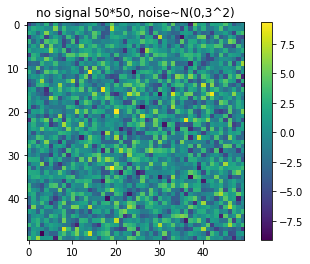

50*50 no signal ERR: 0.02
100*100 no signal ERR: 0.01


In [ ]:
plt.imshow(no_signal_img[0,:,:])
plt.colorbar()
plt.title("no signal 50*50, noise~N(0,3^2)")
plt.show()

nosig_ERR1 = []
num_sim=100
for i in np.arange(num_sim):
  nosig_ERR1.append(fdr_error_check2(n_subj=80, img_dim=(50,50), c=0,
                                     noise_set=noise_spec_homogen, mu_set=no_signal,
                                     var=1, alpha=0.05, tail="two"))

print("50*50 no signal ERR:", np.mean(nosig_ERR1))

nosig_ERR2 = []
num_sim=100
for i in np.arange(num_sim):
  nosig_ERR2.append(fdr_error_check2(n_subj=80, img_dim=(100,100), c=0,
                                     noise_set=noise_spec_homogen, mu_set=no_signal,
                                     var=1, alpha=0.05, tail="two"))

print("100*100 no signal ERR:", np.mean(nosig_ERR2))

In [ ]:
sim_num = 500
ERR = dict()

ERR['lab'] = ["c=0.5", "c=2", "c=3",
               "c=0.5/std=*3", "c=2/std=*3", "c=3/std=*3"]
ERR['small'] = [[],[],[],[],[],[]]
for i in np.arange(sim_num):
  ERR['small'][0].append(fdr_error_check2(n_subj=80, img_dim=(50,50), c=0.5, var=1,
                    noise_set=noise_spec_homogen, mu_set=mu_spec_circle_s_50,
                    alpha=0.05, tail="two"))
  ERR['small'][1].append(fdr_error_check2(n_subj=80, img_dim=(50,50), c=2, var=1,
                    noise_set=noise_spec_homogen, mu_set=mu_spec_circle_s_50,
                    alpha=0.05, tail="two"))
  ERR['small'][2].append(fdr_error_check2(n_subj=80, img_dim=(50,50), c=3, var=1,
                    noise_set=noise_spec_homogen, mu_set=mu_spec_circle_s_50,
                    alpha=0.05, tail="two"))
  ERR['small'][3].append(fdr_error_check2(n_subj=80, img_dim=(50,50), c=0.5, var=3,
                    noise_set=noise_spec_homogen, mu_set=mu_spec_circle_s_50,
                    alpha=0.05, tail="two"))
  ERR['small'][4].append(fdr_error_check2(n_subj=80, img_dim=(50,50), c=2, var=3,
                    noise_set=noise_spec_homogen, mu_set=mu_spec_circle_s_50,
                    alpha=0.05, tail="two"))
  ERR['small'][5].append(fdr_error_check2(n_subj=80, img_dim=(50,50), c=3, var=3,
                    noise_set=noise_spec_homogen, mu_set=mu_spec_circle_s_50,
                    alpha=0.05, tail="two"))

ERR['small_smth'] = [[],[],[],[],[],[]]
for i in np.arange(sim_num):
  ERR['small_smth'][0].append(fdr_error_check2(n_subj=80, img_dim=(50,50), c=0.5, var=1,
                    noise_set=noise_spec_homogen_smth, mu_set=mu_spec_circle_s_50,
                    alpha=0.05, tail="two"))
  ERR['small_smth'][1].append(fdr_error_check2(n_subj=80, img_dim=(50,50), c=2, var=1,
                    noise_set=noise_spec_homogen_smth, mu_set=mu_spec_circle_s_50,
                    alpha=0.05, tail="two"))
  ERR['small_smth'][2].append(fdr_error_check2(n_subj=80, img_dim=(50,50), c=3, var=1,
                    noise_set=noise_spec_homogen_smth, mu_set=mu_spec_circle_s_50,
                    alpha=0.05, tail="two"))
  ERR['small_smth'][3].append(fdr_error_check2(n_subj=80, img_dim=(50,50), c=0.5, var=3,
                    noise_set=noise_spec_homogen_smth, mu_set=mu_spec_circle_s_50,
                    alpha=0.05, tail="two"))
  ERR['small_smth'][4].append(fdr_error_check2(n_subj=80, img_dim=(50,50), c=2, var=3,
                    noise_set=noise_spec_homogen_smth, mu_set=mu_spec_circle_s_50,
                    alpha=0.05, tail="two"))
  ERR['small_smth'][5].append(fdr_error_check2(n_subj=80, img_dim=(50,50), c=3, var=3,
                    noise_set=noise_spec_homogen_smth, mu_set=mu_spec_circle_s_50,
                    alpha=0.05, tail="two"))
  

ERR['large'] = [[],[],[],[],[],[]]
for i in np.arange(sim_num):
  ERR['large'][0].append(fdr_error_check2(n_subj=80, img_dim=(50,50), c=0.5, var=1,
                    noise_set=noise_spec_homogen, mu_set=mu_spec_circle_l_50,
                    alpha=0.05, tail="two"))
  ERR['large'][1].append(fdr_error_check2(n_subj=80, img_dim=(50,50), c=2, var=1,
                    noise_set=noise_spec_homogen, mu_set=mu_spec_circle_l_50,
                    alpha=0.05, tail="two"))
  ERR['large'][2].append(fdr_error_check2(n_subj=80, img_dim=(50,50), c=3, var=1,
                    noise_set=noise_spec_homogen, mu_set=mu_spec_circle_l_50,
                    alpha=0.05, tail="two"))
  ERR['large'][3].append(fdr_error_check2(n_subj=80, img_dim=(50,50), c=0.5, var=3,
                    noise_set=noise_spec_homogen, mu_set=mu_spec_circle_l_50,
                    alpha=0.05, tail="two"))
  ERR['large'][4].append(fdr_error_check2(n_subj=80, img_dim=(50,50), c=2, var=3,
                    noise_set=noise_spec_homogen, mu_set=mu_spec_circle_l_50,
                    alpha=0.05, tail="two"))
  ERR['large'][5].append(fdr_error_check2(n_subj=80, img_dim=(50,50), c=3, var=3,
                    noise_set=noise_spec_homogen, mu_set=mu_spec_circle_l_50,
                    alpha=0.05, tail="two"))
  
ERR['large_smth'] = [[],[],[],[],[],[]]
for i in np.arange(sim_num):
  ERR['large_smth'][0].append(fdr_error_check2(n_subj=80, img_dim=(50,50), c=0.5, var=1,
                    noise_set=noise_spec_homogen_smth, mu_set=mu_spec_circle_l_50,
                    alpha=0.05, tail="two"))
  ERR['large_smth'][1].append(fdr_error_check2(n_subj=80, img_dim=(50,50), c=2, var=1,
                    noise_set=noise_spec_homogen_smth, mu_set=mu_spec_circle_l_50,
                    alpha=0.05, tail="two"))
  ERR['large_smth'][2].append(fdr_error_check2(n_subj=80, img_dim=(50,50), c=3, var=1,
                    noise_set=noise_spec_homogen_smth, mu_set=mu_spec_circle_l_50,
                    alpha=0.05, tail="two"))
  ERR['large_smth'][3].append(fdr_error_check2(n_subj=80, img_dim=(50,50), c=0.5, var=3,
                    noise_set=noise_spec_homogen_smth, mu_set=mu_spec_circle_l_50,
                    alpha=0.05, tail="two"))
  ERR['large_smth'][4].append(fdr_error_check2(n_subj=80, img_dim=(50,50), c=2, var=3,
                    noise_set=noise_spec_homogen_smth, mu_set=mu_spec_circle_l_50,
                    alpha=0.05, tail="two"))
  ERR['large_smth'][5].append(fdr_error_check2(n_subj=80, img_dim=(50,50), c=3, var=3,
                    noise_set=noise_spec_homogen_smth, mu_set=mu_spec_circle_l_50,
                    alpha=0.05, tail="two"))


ERR.update({n: np.round(np.nanmean(ERR[n],axis=1),4) for n in list(ERR.keys())[1:]})


In [ ]:
sim_num = 500
ERR2 = dict()
ERR2['lab'] = ["c=0.5", "c=2", "c=3",
               "c=0.5/std=*3", "c=2/std=*3", "c=3/std=*3"]
ERR2['small'] = [[],[],[],[],[],[]]
for i in np.arange(sim_num):
  ERR2['small'][0].append(fdr_error_check2(n_subj=80, img_dim=(100,100), c=0.5, var=1,
                    noise_set=noise_spec_homogen, mu_set=mu_spec_circle_s_100,
                    alpha=0.05, tail="two"))
  ERR2['small'][1].append(fdr_error_check2(n_subj=80, img_dim=(100,100), c=2, var=1,
                    noise_set=noise_spec_homogen, mu_set=mu_spec_circle_s_100,
                    alpha=0.05, tail="two"))
  ERR2['small'][2].append(fdr_error_check2(n_subj=80, img_dim=(100,100), c=3, var=1,
                    noise_set=noise_spec_homogen, mu_set=mu_spec_circle_s_100,
                    alpha=0.05, tail="two"))
  ERR2['small'][3].append(fdr_error_check2(n_subj=80, img_dim=(100,100), c=0.5, var=3,
                    noise_set=noise_spec_homogen, mu_set=mu_spec_circle_s_100,
                    alpha=0.05, tail="two"))
  ERR2['small'][4].append(fdr_error_check2(n_subj=80, img_dim=(100,100), c=2, var=3,
                    noise_set=noise_spec_homogen, mu_set=mu_spec_circle_s_100,
                    alpha=0.05, tail="two"))
  ERR2['small'][5].append(fdr_error_check2(n_subj=80, img_dim=(100,100), c=3, var=3,
                    noise_set=noise_spec_homogen, mu_set=mu_spec_circle_s_100,
                    alpha=0.05, tail="two"))

ERR2['small_smth'] = [[],[],[],[],[],[]]
for i in np.arange(sim_num):
  ERR2['small_smth'][0].append(fdr_error_check2(n_subj=80, img_dim=(100,100), c=0.5, var=1,
                    noise_set=noise_spec_homogen_smth, mu_set=mu_spec_circle_s_100,
                    alpha=0.05, tail="two"))
  ERR2['small_smth'][1].append(fdr_error_check2(n_subj=80, img_dim=(100,100), c=2, var=1,
                    noise_set=noise_spec_homogen_smth, mu_set=mu_spec_circle_s_100,
                    alpha=0.05, tail="two"))
  ERR2['small_smth'][2].append(fdr_error_check2(n_subj=80, img_dim=(100,100), c=3, var=1,
                    noise_set=noise_spec_homogen_smth, mu_set=mu_spec_circle_s_100,
                    alpha=0.05, tail="two"))
  ERR2['small_smth'][3].append(fdr_error_check2(n_subj=80, img_dim=(100,100), c=0.5, var=3,
                    noise_set=noise_spec_homogen_smth, mu_set=mu_spec_circle_s_100,
                    alpha=0.05, tail="two"))
  ERR2['small_smth'][4].append(fdr_error_check2(n_subj=80, img_dim=(100,100), c=2, var=3,
                    noise_set=noise_spec_homogen_smth, mu_set=mu_spec_circle_s_100,
                    alpha=0.05, tail="two"))
  ERR2['small_smth'][5].append(fdr_error_check2(n_subj=80, img_dim=(100,100), c=3, var=3,
                    noise_set=noise_spec_homogen_smth, mu_set=mu_spec_circle_s_100,
                    alpha=0.05, tail="two"))

ERR2['large'] = [[],[],[],[],[],[]]
for i in np.arange(sim_num):
  ERR2['large'][0].append(fdr_error_check2(n_subj=80, img_dim=(100,100), c=0.5, var=1,
                    noise_set=noise_spec_homogen, mu_set=mu_spec_circle_l_100,
                    alpha=0.05, tail="two"))
  ERR2['large'][1].append(fdr_error_check2(n_subj=80, img_dim=(100,100), c=2, var=1,
                    noise_set=noise_spec_homogen, mu_set=mu_spec_circle_l_100,
                    alpha=0.05, tail="two"))
  ERR2['large'][2].append(fdr_error_check2(n_subj=80, img_dim=(100,100), c=3, var=1,
                    noise_set=noise_spec_homogen, mu_set=mu_spec_circle_l_100,
                    alpha=0.05, tail="two"))
  ERR2['large'][3].append(fdr_error_check2(n_subj=80, img_dim=(100,100), c=0.5, var=3,
                    noise_set=noise_spec_homogen, mu_set=mu_spec_circle_l_100,
                    alpha=0.05, tail="two"))
  ERR2['large'][4].append(fdr_error_check2(n_subj=80, img_dim=(100,100), c=2, var=3,
                    noise_set=noise_spec_homogen, mu_set=mu_spec_circle_l_100,
                    alpha=0.05, tail="two"))
  ERR2['large'][5].append(fdr_error_check2(n_subj=80, img_dim=(100,100), c=3, var=3,
                    noise_set=noise_spec_homogen, mu_set=mu_spec_circle_l_100,
                    alpha=0.05, tail="two"))
  
ERR2['large_smth'] = [[],[],[],[],[],[]]
for i in np.arange(sim_num):
  ERR2['large_smth'][0].append(fdr_error_check2(n_subj=80, img_dim=(100,100), c=0.5, var=1,
                    noise_set=noise_spec_homogen_smth, mu_set=mu_spec_circle_l_100,
                    alpha=0.05, tail="two"))
  ERR2['large_smth'][1].append(fdr_error_check2(n_subj=80, img_dim=(100,100), c=2, var=1,
                    noise_set=noise_spec_homogen_smth, mu_set=mu_spec_circle_l_100,
                    alpha=0.05, tail="two"))
  ERR2['large_smth'][2].append(fdr_error_check2(n_subj=80, img_dim=(100,100), c=3, var=1,
                    noise_set=noise_spec_homogen_smth, mu_set=mu_spec_circle_l_100,
                    alpha=0.05, tail="two"))
  ERR2['large_smth'][3].append(fdr_error_check2(n_subj=80, img_dim=(100,100), c=0.5, var=3,
                    noise_set=noise_spec_homogen_smth, mu_set=mu_spec_circle_l_100,
                    alpha=0.05, tail="two"))
  ERR2['large_smth'][4].append(fdr_error_check2(n_subj=80, img_dim=(100,100), c=2, var=3,
                    noise_set=noise_spec_homogen_smth, mu_set=mu_spec_circle_l_100,
                    alpha=0.05, tail="two"))
  ERR2['large_smth'][5].append(fdr_error_check2(n_subj=80, img_dim=(100,100), c=3, var=3,
                    noise_set=noise_spec_homogen_smth, mu_set=mu_spec_circle_l_100,
                    alpha=0.05, tail="two"))

ERR2.update({n: np.round(np.nanmean(ERR2[n],axis=1),4) for n in list(ERR2.keys())[1:]})


$FDR = E[\frac{N_{01}}{max(1,R)}] ≤ \frac{\alpha m_0}{m} $

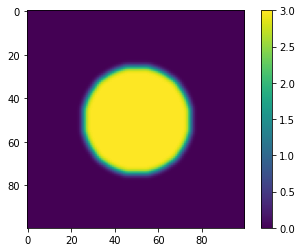

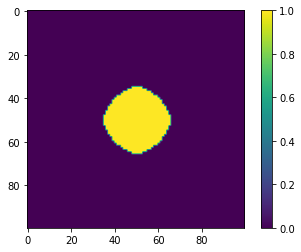

voxels ==2: 0
4781
alpha*m0/m = 0.00056 for small circle(50*50)
alpha*m0/m = 0.00112 for larger circle(50*50)
alpha*m0/m = 0.0005 for small circle(100*100)
alpha*m0/m = 0.00098 for larger circle(100*100)


In [ ]:
up2, lo2 =2.2, 1.8 # 
plt.imshow(mu_circular_s100[0,:,:])
plt.colorbar()
plt.show()
plt.imshow(mu_circular_s100[0,:,:] == 3)
plt.colorbar()
plt.show()

m0_small50 = np.sum(np.logical_and(mu_circular_s[0,:,:] < up2, mu_circular_s[0,:,:] > lo2))
m0_small50_c05 = np.sum(mu_circular_s[0,:,:] == 0.5)
m0_small50_c3 = np.sum(mu_circular_s[0,:,:] == 3)

m0_large50 = np.sum(np.logical_and(mu_circular_l[0,:,:] < up2, mu_circular_l[0,:,:] > lo2))
m0_large50_c05 = np.sum(mu_circular_l[0,:,:] == 0.5)
m0_large50_c3 = np.sum(mu_circular_l[0,:,:] == 3)

m0_small100 = np.sum(np.logical_and(mu_circular_s100[0,:,:] < up2, mu_circular_s100[0,:,:] > lo2))
m0_small100_c05 = np.sum(mu_circular_s100[0,:,:] == 0.5)
m0_small100_c3 = np.sum(mu_circular_s100[0,:,:] == 3)

m0_large100 = np.sum(np.logical_and(mu_circular_l100[0,:,:] < up2, mu_circular_l100[0,:,:] > lo2))
m0_large100_c05 = np.sum(mu_circular_l100[0,:,:] == 0.5)
m0_large100_c3 = np.sum(mu_circular_l100[0,:,:] == 3)

print("voxels ==2:", np.sum(mu_circular_s[0,:,:] == 2))
print(m0_large100_c3)
#print(m0_small50); print(m0_large50);print(m0_small100);print(m0_large100)

print("alpha*m0/m =", np.round(0.05*m0_small50/(50*50),6), "for small circle(50*50)")
print("alpha*m0/m =", round(0.05*m0_large50/(50*50),6), "for larger circle(50*50)")
print("alpha*m0/m =", np.round(0.05*m0_small100/(100*100),6), "for small circle(100*100)")
print("alpha*m0/m =", np.round(0.05*m0_large100/(100*100),6), "for larger circle(100*100)")



In [ ]:
print("--------------------------FDR ERR--------------------------")
print("---------------------imagesize:(50*50)---------------------")
print(tabulate(ERR, headers="keys"))
print(":alpha*m0/m =", np.round(0.05*m0_small50_c05/(50*50),5), "for small circle(50*50), c=0.5")
print(":alpha*m0/m =", np.round(0.05*m0_small50/(50*50),5), "for small circle(50*50), c=2")
print(":alpha*m0/m =", np.round(0.05*m0_small50_c3/(50*50),5), "for small circle(50*50), c=2")
print()
print(":alpha*m0/m =", np.round(0.05*m0_large50_c05/(50*50),5), "for larger circle(50*50), c=0.5")
print(":alpha*m0/m =", np.round(0.05*m0_large50/(50*50),5), "for larger circle(50*50), c=2")
print(":alpha*m0/m =", np.round(0.05*m0_large50_c3/(50*50),5), "for larger circle(50*50), c=3")

print()
print()
print("--------------------imagesize:(100*100)--------------------")
print(tabulate(ERR2, headers="keys"))
print()
print("alpha*m0/m =", np.round(0.05*m0_small100_c05/(100*100),5), "for small circle(100*100), c=0.5")
print("alpha*m0/m =", np.round(0.05*m0_small100/(100*100),5), "for small circle(100*100), c=2")
print("alpha*m0/m =", np.round(0.05*m0_small100_c3/(100*100),5), "for small circle(100*100), c=3")
print()
print("alpha*m0/m =", np.round(0.05*m0_large100_c05/(100*100),5), "for larger circle(100*100), c=0.5")
print("alpha*m0/m =", np.round(0.05*m0_large100/(100*100),5), "for larger circle(100*100), c=2")
print("alpha*m0/m =", np.round(0.05*m0_large100_c3/(100*100),5), "for larger circle(100*100), c=3")
print()
print("!some settings yielded no rejected voxels -> no lower/upper conf sets created, ERR=0")

--------------------------FDR ERR--------------------------
---------------------imagesize:(50*50)---------------------
lab             small    small_smth    large    large_smth
------------  -------  ------------  -------  ------------
c=0.5          0.0004        0.0005   0.0007        0.0008
c=2            0.0001        0.0001   0.0002        0.0003
c=3            0.0036        0.004    0.0162        0.0169
c=0.5/std=*3   0.0038        0.0076   0.0023        0.0023
c=2/std=*3     0.0004        0.0008   0.0008        0.0009
c=3/std=*3     0.0037        0.0035   0.0165        0.0129
:alpha*m0/m = 0.0 for small circle(50*50), c=0.5
:alpha*m0/m = 0.00112 for small circle(50*50), c=2
:alpha*m0/m = 0.00314 for small circle(50*50), c=2

:alpha*m0/m = 0.0 for larger circle(50*50), c=0.5
:alpha*m0/m = 0.00216 for larger circle(50*50), c=2
:alpha*m0/m = 0.02306 for larger circle(50*50), c=3


--------------------imagesize:(100*100)--------------------
lab             small    small_smth    l

# Flags

#1 No inference on upper/lower confidence set (no rejection from BH)

this leads to no ERR for c=0 no signal image

In [ ]:
n_subj=80
img_dim=(50,50)
data_dim = np.array((n_subj,) + img_dim)
noise = get_noise(noise_spec_homogen, data_dim)*100
mu = get_mu(no_signal, data_dim)
data = mu + noise
c=0

lower, upper, Achat, all_sets = fdr_cope(data, threshold=0, alpha=0.05, tail="two")

plt.imshow(data[0,:,:])
plt.colorbar()
plt.title("data")
plt.show()
plt.imshow(lower)
plt.title("lower")
plt.colorbar()
plt.show()
plt.imshow(upper)
plt.title("upper")
plt.colorbar()
plt.show()

Ac = mu>=c
AcC = 1-Ac
  
numer = np.sum(np.minimum(np.maximum(upper - Ac.astype(int), 0) + np.maximum(Ac.astype(int) - lower, 0), 1))
denom = np.sum(np.minimum(upper + (1-lower), 1) )

if denom == 0:
  ERR = math.nan
else:
  ERR = numer / denom

print(ERR)

sim_num = 5000
ERR_nosig = []
for i in np.arange(sim_num):
  ERR_nosig.append(fdr_error_check2(n_subj=80, img_dim=(100,100), c=0, var=1,
                                    noise_set=noise_spec_homogen, mu_set=no_signal,
                                    alpha=0.05, tail="two"))
print(np.nanmean(ERR_nosig))
print(ERR_nosig)